## Simple example of searching for a strategy with pandas 

This is a simple example to research a strategy with python and pandas. Here, we don't smooth the prices, we don't apply transaction fees, we don't varify volumes.

In [1]:
import pandas as pd
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import time

### Utils

In [2]:
ONE_HOURE_MS = 1000*60*60
INFO = True

def pctEvol(first,last):
    return (((last - first) / first)*100)

In [3]:
buyPct = -1
sellPct = 0.5
sellSecurityPct = -2

### Loading files

In [4]:
df = pd.DataFrame();

startTimeFile = 1519297200000
endTimeFile = 1519916400000 
timeFile = startTimeFile
while(timeFile < endTimeFile):
    filePath = "../data/sec/ETHBTC/"+str(timeFile)+".txt"
    timeFile += ONE_HOURE_MS
    if(path.isfile(filePath)):
        print(filePath)
        dfFile = pd.read_csv(filePath)
        dfFile['DATE'] = pd.to_datetime(dfFile['DATE'])
        # Add file to main dataframe
        # ignore_index=True -> reset index
        df = df.append(dfFile, ignore_index=True)
        df = df.sort_values(['DATE'])
df['ID'] = df.index.values
df.set_index('DATE', inplace=True)
if(INFO): print("info :", df.index.size, "lines loaded")

../data/sec/ETHBTC/1519297200000.txt
../data/sec/ETHBTC/1519300800000.txt
../data/sec/ETHBTC/1519304400000.txt
../data/sec/ETHBTC/1519308000000.txt
../data/sec/ETHBTC/1519311600000.txt
../data/sec/ETHBTC/1519315200000.txt
../data/sec/ETHBTC/1519318800000.txt
../data/sec/ETHBTC/1519322400000.txt
../data/sec/ETHBTC/1519326000000.txt
../data/sec/ETHBTC/1519329600000.txt
../data/sec/ETHBTC/1519333200000.txt
../data/sec/ETHBTC/1519336800000.txt
../data/sec/ETHBTC/1519340400000.txt
../data/sec/ETHBTC/1519344000000.txt
../data/sec/ETHBTC/1519347600000.txt
../data/sec/ETHBTC/1519351200000.txt
../data/sec/ETHBTC/1519354800000.txt
../data/sec/ETHBTC/1519358400000.txt
../data/sec/ETHBTC/1519362000000.txt
../data/sec/ETHBTC/1519365600000.txt
../data/sec/ETHBTC/1519369200000.txt
../data/sec/ETHBTC/1519372800000.txt
../data/sec/ETHBTC/1519376400000.txt
../data/sec/ETHBTC/1519380000000.txt
../data/sec/ETHBTC/1519383600000.txt
../data/sec/ETHBTC/1519387200000.txt
../data/sec/ETHBTC/1519390800000.txt
.

In [5]:
df.head(2)

,PRICE,VOLUME,ID
DATE,,,
2018-02-22 12:05:32,0.080750,0.061,0
2018-02-22 12:05:32,0.080725,0.049,1


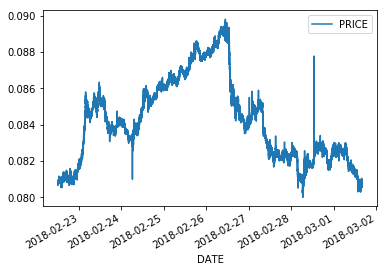

In [6]:
df.plot(y=['PRICE']);
plt.show();

### Buy orders

In [7]:
# Prix max sur les 60 dernières secondes
df['MAX_PRICE_1MIN'] = df['PRICE'].shift(1)
df['MAX_PRICE_1MIN'] = df['MAX_PRICE_1MIN'].rolling('60s').max()
# Chute de -2% sur une periode de 1 min par rapport au prix max
df['BUY1'] = pctEvol(df['MAX_PRICE_1MIN'],df['PRICE']) < buyPct
# On met à false les ordres d'achat qui sont après le premier ordre d'achat sur une période de 1min
df['BUY2'] = df['BUY1'].shift(1).rolling('60s').apply(lambda x: (True in x) == False, raw=True)
# Combinaison des conditions
df['BUY'] = (df['BUY1'] == True) & (df['BUY2'] == True)
# On indique le prix d'achat après un ordre d'achat
df['BUY_PRICE'] = np.where(df['BUY'].shift(1)==True, df['PRICE'].shift(1), np.nan )
#df['BUY3'] = df[df['BUY'] == True]['PRICE'].shift(freq='1s').rolling('10s').min()
df = df.fillna(method='ffill')
# Nombdre d'ordre d'achat
orderBuy = df[:][df['BUY'] == True]
if(INFO): print ("info :", "number order buy =",orderBuy['ID'].values.size)

info : number order buy = 9


### Sell orders

In [8]:
 # Il y a eu un achat présent avant
df['SELL1'] = (np.isfinite(df['BUY_PRICE'])) & (df['BUY'] == False)
# On met un délai de 2 secondes après un achat pour pouvoir vendre
df['SELL2'] = df['BUY'].shift(1).rolling('2s').apply(lambda x: (True in x) == False, raw=True)
# Pourcentage évolution
df['SELL3'] = (pctEvol(df['BUY_PRICE'],df['PRICE']) >= sellPct) | (pctEvol(df['BUY_PRICE'],df['PRICE']) <= sellSecurityPct)
# Combinaison des conditions
df['SELL4'] = (df['SELL1'] == True) & (df['SELL2'] == True) & (df['SELL3'] == True)
# On récupère la première ligne pour chaque ordre de vente
idValues = df[:][df['SELL4'] == True].groupby(['BUY_PRICE','SELL4']).first()['ID'].values
df['SELL'] = df['ID'].isin(idValues)
# Nombre d'ordre de vente
orderSellGood = df[:][(df['SELL'] == True) & (df['PRICE'] > df['BUY_PRICE'])]
orderSellSecurity = df[:][(df['SELL'] == True) & (df['PRICE'] < df['BUY_PRICE'])]

### Analyse

In [9]:
if(INFO): print ("info :", "number order sell good =",orderSellGood['ID'].values.size)
if(INFO): print ("info :", "number order sell security =", orderSellSecurity['ID'].values.size)
if(INFO): print("buyPct =", buyPct, " sellPct =", sellPct, " sellSecurityPct =", sellSecurityPct)

info : number order sell good = 9
info : number order sell security = 0
buyPct = -1  sellPct = 0.5  sellSecurityPct = -2
